In [111]:
### TODO: set your own directories
import os
from PIL import Image
import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import natsort
from PIL import Image
from torch.utils.data import DataLoader, Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, " will be used.\n")

data_dir = '../../data/'
# preprocessed_dir = '../../data_preprocessed/'
result_dir = '../../results/'

print(os.getcwd())

cpu  will be used.

C:\Users\kwyma\OneDrive - UW\MasterWork\_UW - Grad\Deep Learning\Landscape-Generation-GAN\src


In [114]:
### Params

# data
image_size = 512
batch_size = 128

# model
num_channels = 3
input_size = 512
output_size = 1
gen_filter = 256
dis_filter = 256

# random seed
seed = 500
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# training - TODO: figure out how to use these
nz = 100 # latent vector Z (generator input?)
ngf = 64 # Size of feature maps in the generator. The depth will be multiples of this.
ndf = 64 # Size of features maps in the discriminator. The depth will be multiples of this.
nepochs = 10 # Number of training epochs.
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizer
save_epoch = 2 # Save step.

Random Seed:  500


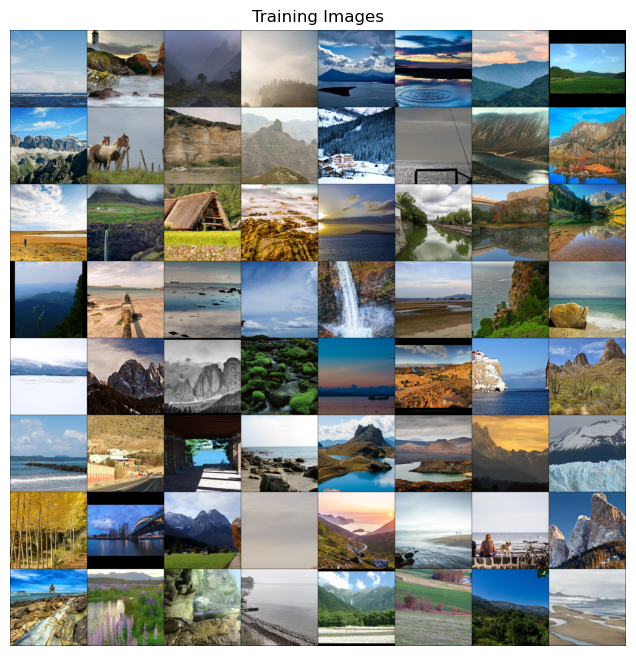

In [115]:
class LandscapeDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_images = os.listdir(main_dir)
        self.total_images = natsort.natsorted(all_images)

    def __len__(self):
        return len(self.total_images)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_images[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

transform = transforms.Compose([
                                transforms.CenterCrop(image_size), # if saving preproc, disable
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                ])

# NOTE: if saving pre proc, use preprocessed_dir
landscape_data = LandscapeDataset(data_dir, transform=transform)
data_loader = DataLoader(dataset=landscape_data, batch_size=batch_size, shuffle=True)

# for testing
# data_loader = DataLoader(dataset=landscape_data, batch_size=4, shuffle=False)

# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [116]:
import torch.nn as nn

# Generator of DC-GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(input_size, gen_filter * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(gen_filter * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_filter * 8, gen_filter * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(gen_filter * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_filter * 4, gen_filter * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(gen_filter * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_filter * 2, gen_filter, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(gen_filter),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_filter, num_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


# Discriminator of DC-GAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_channels, dis_filter, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_filter, dis_filter * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(dis_filter * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_filter * 2, dis_filter * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(dis_filter * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_filter * 4, dis_filter * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(dis_filter * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_filter * 8, output_size, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# custom weights initialization with mean=0, stdev=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(m.bias.data, 0)

        
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(512, 2048, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), pad

In [ ]:
# borrowed from github - training code
import torch.optim as optim
import matplotlib.animation as animation
import random

# TODO: repurpose below training code for above models/params
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)

real_label = 1
fake_label = 0

# Optimizer for the discriminator.
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
# Optimizer for the generator.
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

# Stores generated images as training progresses.
img_list = []
# Stores generator losses during training.
G_losses = []
# Stores discriminator losses during training.
D_losses = []

iters = 0

print("Starting Training Loop...")
print("-"*25)

for epoch in range(params['nepochs']):
    for i, data in enumerate(dataloader, 0):
        # Transfer data tensor to GPU/CPU (device)
        real_data = data[0].to(device)
        # Get batch size. Can be different from params['nbsize'] for last batch in epoch.
        b_size = real_data.size(0)
        
        # Make accumalated gradients of the discriminator zero.
        netD.zero_grad()
        # Create labels for the real data. (label=1)
        label = torch.full((b_size, ), real_label, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        # Calculate gradients for backpropagation.
        errD_real.backward()
        D_x = output.mean().item()
        
        # Sample random data from a unit normal distribution.
        noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
        # Generate fake data (images).
        fake_data = netG(noise)
        # Create labels for fake data. (label=0)
        label.fill_(fake_label  )
        # Calculate the output of the discriminator of the fake data.
        # As no gradients w.r.t. the generator parameters are to be
        # calculated, detach() is used. Hence, only gradients w.r.t. the
        # discriminator parameters will be calculated.
        # This is done because the loss functions for the discriminator
        # and the generator are slightly different.
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        # Calculate gradients for backpropagation.
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Net discriminator loss.
        errD = errD_real + errD_fake
        # Update discriminator parameters.
        optimizerD.step()
        
        # Make accumalted gradients of the generator zero.
        netG.zero_grad()
        # We want the fake data to be classified as real. Hence
        # real_label are used. (label=1)
        label.fill_(real_label)
        # No detach() is used here as we want to calculate the gradients w.r.t.
        # the generator this time.
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        # Gradients for backpropagation are calculated.
        # Gradients w.r.t. both the generator and the discriminator
        # parameters are calculated, however, the generator's optimizer
        # will only update the parameters of the generator. The discriminator
        # gradients will be set to zero in the next iteration by netD.zero_grad()
        errG.backward()

        D_G_z2 = output.mean().item()
        # Update generator parameters.
        optimizerG.step()

        # Check progress of training.
        if i%50 == 0:
            print(torch.cuda.is_available())
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, params['nepochs'], i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save the losses for plotting.
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on a fixed noise.
        if (iters % 100 == 0) or ((epoch == params['nepochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_data = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))

        iters += 1

    # Save the model.
    if epoch % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/model_epoch_{}.pth'.format(epoch))

# Save the final trained model.
torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/model_final.pth')

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
plt.show()
anim.save('celeba.gif', dpi=80, writer='imagemagick')

In [ ]:
# borrowed from github - generator code
import argparse

import torch
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

from dcgan import Generator

parser = argparse.ArgumentParser()
parser.add_argument('-load_path', default='model/model_final.pth', help='Checkpoint to load path from')
parser.add_argument('-num_output', default=64, help='Number of generated outputs')
args = parser.parse_args()

# Load the checkpoint file.
state_dict = torch.load(args.load_path)

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
# Get the 'params' dictionary from the loaded state_dict.
params = state_dict['params']

# Create the generator network.
netG = Generator(params).to(device)
# Load the trained generator weights.
netG.load_state_dict(state_dict['generator'])
print(netG)

print(args.num_output)
# Get latent vector Z from unit normal distribution.
noise = torch.randn(int(args.num_output), params['nz'], 1, 1, device=device)

# Turn off gradient calculation to speed up the process.
with torch.no_grad():
	# Get generated image from the noise vector using
	# the trained generator.
    generated_img = netG(noise).detach().cpu()

# Display the generated image.
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0)))

plt.show()